## Modelo de Serie Temporal para el Caudal Volumétrico Presa Chicayán

Se presenta un análisis exploratorio para un modelo de series de tiempo tipo *Modelo Estacional Autorregresivo Integrado De Media Móvil Exógena* **(SARIMAX)**, con el objetivo de encontrar un modelo con un buen ajuste que permita pronosticar los flujos volumétricos futuros, y con ellos una posible proyección de déficit de agua en el nivel de esta presa.

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

### Datos Históricos de Caudal Volumétrico

Este conjunto de datos contiene promedios anuales (en Mm3) de caudales volumétricos de entrada para la presa Chicayán en el período 1979 a 2024.

In [373]:
data = pd.read_csv(r'Inlet_Dates.csv')
data.head()

,Year,Inlet
0,1979-01-01,176
1,1980-01-01,90
2,1981-01-01,913
3,1982-01-01,30
4,1983-01-01,86


[Text(0.5, 1.0, 'Chicayan Water Inlet Volume (Mm3)'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Volume (Mm3)')]

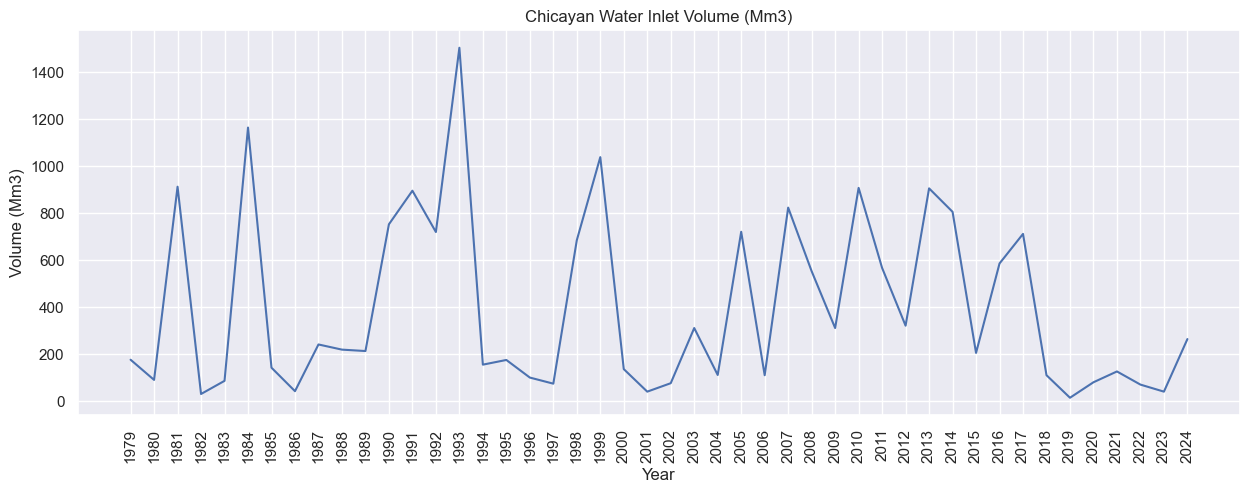

In [443]:
data['Y'] = data['Year'].str[:4]
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.lineplot(x="Y", y="Inlet",data=data).set(title="Chicayan Water Inlet Volume (Mm3)",xlabel='Year', ylabel='Volume (Mm3)')

### Análisis de Estacionariedad

El **análisis de estacionariedad** en series temporales consiste en determinar si las propiedades estadísticas (media, varianza y autocorrelación) de una serie temporal permanecen constantes a lo largo del tiempo. Este concepto es fundamental para el análisis y la modelización de series temporales, ya que muchos modelos, como ARIMA, asumen que la serie es estacionaria. 

**¿Por qué es importante la estacionariedad?**
- Predicción: Si una serie es estacionaria, se asume que sus propiedades estadísticas futuras serán similares a las del pasado. Esto facilita la predicción, ya que se puede utilizar información pasada para predecir valores futuros.
- Modelización: Muchos modelos estadísticos, como SARIMAX, requieren que la serie sea estacionaria para poder funcionar correctamente. Al no ser estacionaria, se puede plantear la serie como una función del tiempo, lo que complica la modelización. 
- Análisis: La estacionariedad facilita el análisis de la serie, ya que permite identificar tendencias y estacionalidades de forma más clara.

#### ADF Test
La prueba de Dickey-Fuller Aumentada (ADF) es una prueba estadística que se utiliza para *determinar si una serie temporal es estacionaria o no*. Es una extensión de la prueba de Dickey-Fuller y permite tener en cuenta procesos autorregresivos de orden superior. 

In [377]:
serie = pd.Series(data['Inlet'].values, index=pd.date_range("1979-01-01", periods=len(data['Inlet']), freq="YS"))

In [378]:
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [379]:
check_stationarity(serie)

ADF Statistic: -5.849617
p-value: 0.000000
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
Stationary


La serie temporal es **estacionaria**. Esto permite el modelado autorregresivo!

Para tener una idea del orden de los componentes AR (Autorregresivo p), Diferencial (d) y MA (Media Móvil q), se inspeccionan los gráficos de:
- Función de Auto-Correlación (ACF)
- Función de Auto-Correlación Parcial (PACF)

La evaluación de la significancia de los lags permite identificar posibles candidatos a modelos del tipo **SARIMAX(p,d,q)**.

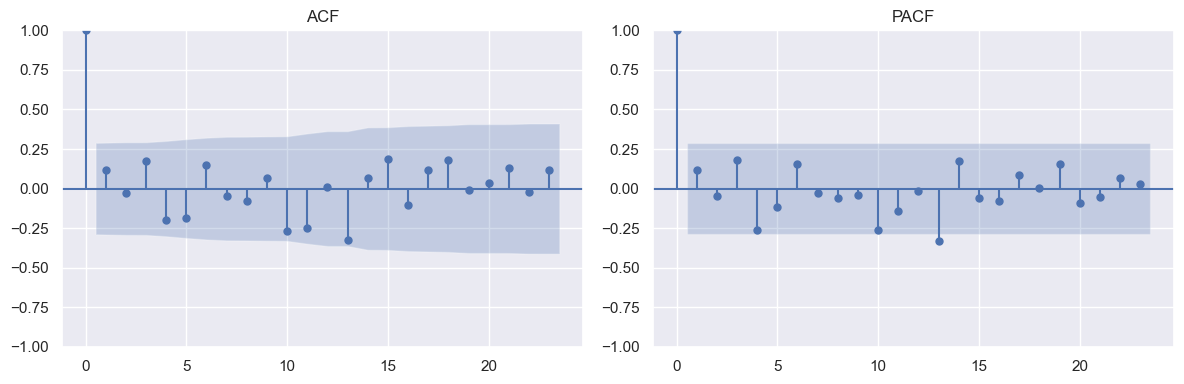

In [380]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(serie, lags=23, ax=plt.gca())
plt.title("ACF")
plt.subplot(1, 2, 2)
plot_pacf(serie, lags=23, ax=plt.gca(), method="ywm")
plt.title("PACF")
plt.tight_layout()
plt.show()

Estos gráficos no muestran significancias claras en ninguno de los lags, a **excepción del lag 13 en el gráfico PACF**. Esto implica una *posible correlación con eventos de 13 años atrás*, es decir, un modelo autorregresivo de orden 13. En el gráfico ACF se observa también un valor cercano al límite de significancia en el lag 13.

Dada esta falta de claridad en los gráficos, se realizará un análisis ***Grid Search*** en donde se entrenaran diferentes modelos con diversas combinaciones, con el objetivo de poder encontrar el modelo *con el mejor ajuste*, definiéndolo en función de su MAE (Error Medio Absoluto).

### Análisis Grid Search para Selección de Modelos SARIMAX

En este caso, dado que los gráfico ACF y PACF muestran posibles dependencias de largo plazo, deberemos incluir Lags de varios años atrás dentro del espacio de exploración.

Definimos la "malla" de exploración de la siguiente manera:
- Espacio de Orden **Autorregresivo** *p*: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
- Espacio de Orden **Diferencial** *d*: [0,1,2]
- Espacio de Orden **Media Móvil** *q* : [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

El espacio definido contempla la evaluación de 17x3x17 = 867 modelos, entre los cuales **se elegirá el de menor Mean Absolute Error**.

In [382]:
def SARIMAX_grid_search(lista_p,lista_d,lista_q,series):

    model_list = []

    for p in lista_p:
        for d in lista_d:
            for q in lista_q:
                model = SARIMAX(
                    series,
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit()
                model_list.append((p,d,q,results.aic,results.bic,results.mae))
    return model_list

In [389]:
lista_p = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lista_d = [0,1,2]
lista_q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

modelos = SARIMAX_grid_search(lista_p,lista_d,lista_q,serie)

In [390]:
print("Se han evaluado",len(aic),"modelos.")

Se han evaluado 867 modelos.


Se busca el mejor modelo, basado en el criterio de *menor Error Medio Absoluto*:

In [401]:
def find_min_mae(list_of_tuples):
    
    if not list_of_tuples:
        return -1

    min_val = float('inf')  # Inicializar con un valor grande
    min_index = -1

    for index, tup in enumerate(list_of_tuples):
        if len(tup) >= 4 and tup[5] < min_val:
            min_val = tup[5]
            min_index = index

    return list_of_tuples[min_index]

In [402]:
find_min_mae(modelos)

(14,
 0,
 13,
 np.float64(504.8833654295214),
 np.float64(545.9239707079138),
 np.float64(214.9821069261751))

El mejor modelo lo constituye un **SARIMAX(14,0,13)** con un **MAE de 214.98**.

In [403]:
# Ajustar el modelo SARIMA(14, 0, 13)(0, 0, 0)[0]
model = SARIMAX(
    serie,
    order=(14, 0, 13),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())
print("Error Medio Absoluto:",results.mae)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:             SARIMAX(14, 0, 13)   Log Likelihood                -224.442
Date:                Sun, 04 May 2025   AIC                            504.883
Time:                        22:12:28   BIC                            545.924
Sample:                    01-01-1979   HQIC                           518.487
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7207      8.503      0.085      0.932     -15.946      17.387
ar.L2          0.0904      7.809      0.012      0.991     -15.216      15.396
ar.L3          0.4739      9.580      0.049      0.9

Verificamos el comportamiento de los residuales, que deben de carecer de tendencias y ser lo más parecidos a "ruido blanco".

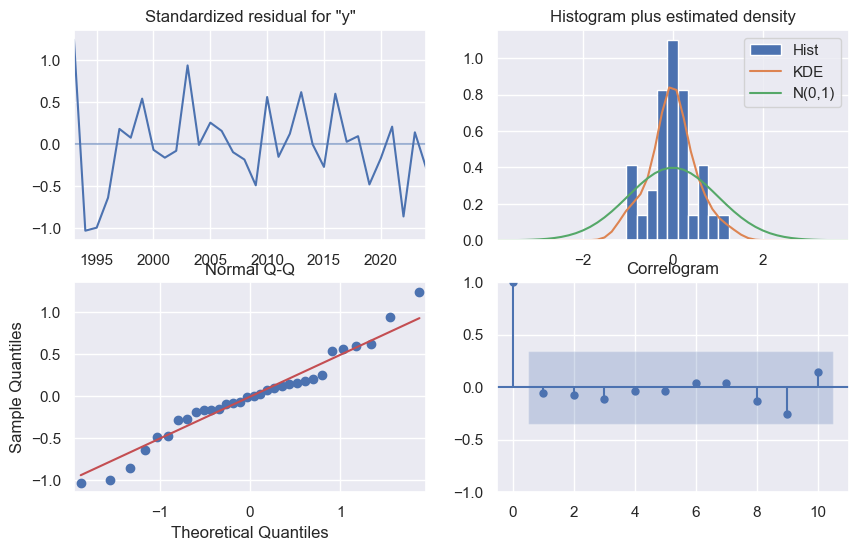

In [404]:
# Graficar residuales
results.plot_diagnostics(figsize=(10, 6))
plt.show()

### Predicciones

Inicialmente verificamos el ajuste del modelo a los datos históricos, por medio de comparar las predicciones con los valores reales de caudal volumétrico.

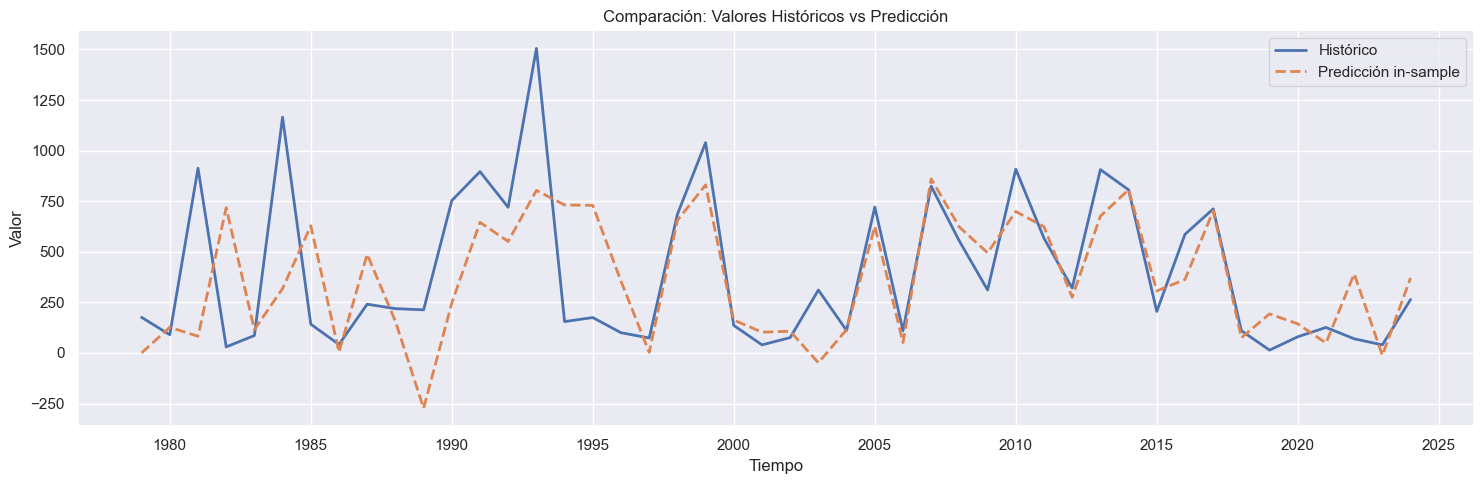

In [444]:
# Obtener predicciones in-sample (dentro de la muestra de entrenamiento)
pred = results.get_prediction(start=0, end=len(serie)-1)
pred_mean = pred.predicted_mean

# Graficar serie original y predicción
plt.figure(figsize=(15, 5))
plt.plot(serie, label='Histórico', linewidth=2)
plt.plot(pred_mean, label='Predicción in-sample', linestyle='--', linewidth=2)
plt.title('Comparación: Valores Históricos vs Predicción')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Posteriormente generamos predicciones para un período de 20 años en el futuro

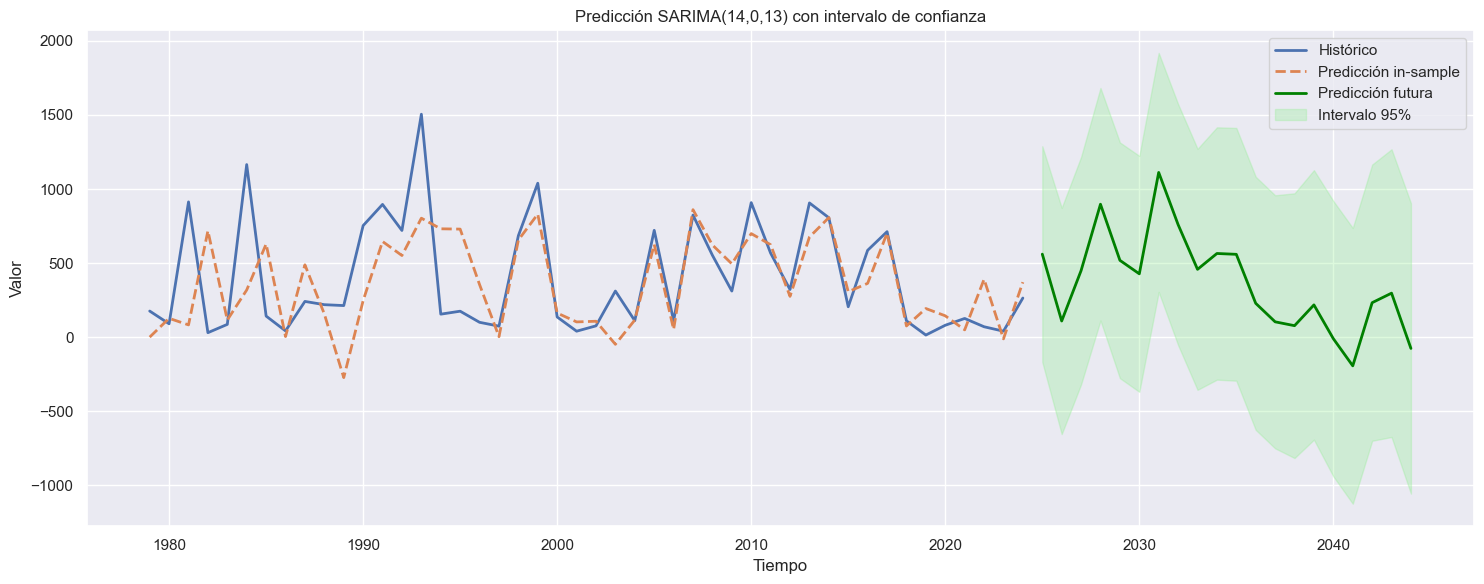

In [447]:
# Número de pasos hacia el futuro
pasos_futuros = 20

# Generar predicción out-of-sample
forecast = results.get_forecast(steps=pasos_futuros)

# Extraer media de la predicción y el intervalo de confianza
pred_mean_futuro = forecast.predicted_mean
conf_int = forecast.conf_int()

# Construir índice de tiempo para las predicciones futuras
index_futuro = pd.date_range(start=serie.index[-1] + pd.DateOffset(years=1),
                             periods=pasos_futuros,
                             freq='YS')

# Visualización completa
plt.figure(figsize=(15, 6))

# Parte histórica
plt.plot(serie, label='Histórico', linewidth=2)

# Predicción in-sample (opcional)
pred_in_sample = results.get_prediction(start=0, end=len(serie)-1).predicted_mean
plt.plot(pred_in_sample, label='Predicción in-sample', linestyle='--', linewidth=2)

# Predicción futura
plt.plot(index_futuro, pred_mean_futuro, label='Predicción futura', color='green', linewidth=2)

# Intervalo de confianza
plt.fill_between(index_futuro,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3, label='Intervalo 95%')


plt.title('Predicción SARIMA(14,0,13) con intervalo de confianza')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El pronóstico tiene valores menores a 0, lo cual es imposible para la entrada. Se limitará a un valor de cero para ser congruentes con la limitación física.

In [420]:
serie_inlet = np.maximum(forecast.predicted_mean.values,0)
serie_inlet

array([ 560.32106327,  108.93375259,  448.98336413,  897.30535629,
        518.44655523,  427.28725569, 1111.84555467,  759.84446725,
        457.62111134,  564.68145637,  559.00913828,  228.30375454,
        103.23204031,   77.22376828,  217.53802825,    0.        ,
          0.        ,  232.53854671,  296.82860808,    0.        ])

### Análisis de Balance Hídrico de Presa Chicayán

Basado en los pronósticos de Caudal Volumétrico de Entrada a la presa, pueden correrse escenarios **para determinar si algún año tendrá déficit de agua**, cuando su nivel operativo sea menor o igual a 0.

In [413]:
def balance_hidrico(inlet_sequence,max_volume,irrigation_outlet,losses):

    balance = []
    max_irrigation_outlet = 0
    min_volume = 135
    balance_previous_year = 229.36

    for i in range(len(inlet_sequence)):
        Vt = inlet_sequence[i] + balance_previous_year
        overflow = max(Vt-max_volume,0)
        net_volume = max(Vt - overflow - irrigation_outlet - losses,0)
        operative_volume = net_volume - min_volume

        registro = [2025+i,inlet_sequence[i],Vt,overflow,balance_previous_year,net_volume,operative_volume]

        balance.append(registro)
    
        balance_previous_year = net_volume

    df = pd.DataFrame(balance,columns=['year','inlet','Vt','overflow','balance_previous_year','net_volume','operative_volume'])
    deficit_count = df[df['operative_volume']<0]['year'].count()

    print("Con una capacidad de",max_volume,"Mm3, un consumo de",irrigation_outlet,"Mm3 y unas pérdidas de",losses,"Mm3, el número de años esperado con déficit en los próximos",len(inlet_sequence),"años es:",deficit_count)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['year'],df['operative_volume'])
    plt.title("Volumen Operativo [Mm3]")
    plt.xlabel("Año")
    plt.ylabel("Volumen Operativo [Mm3]")
    plt.grid(True)
    
    return deficit_count,df

### Escenario 1

Con una capacidad de 250 Mm3, un consumo de 79.2 Mm3 y unas pérdidas de 18 Mm3, el número de años esperado con déficit en los próximos 20 años es: 4


,year,inlet,Vt,overflow,balance_previous_year,net_volume,operative_volume
0,2025,560.321063,789.681063,539.681063,229.360000,152.800000,17.800000
1,2026,108.933753,261.733753,11.733753,152.800000,152.800000,17.800000
2,2027,448.983364,601.783364,351.783364,152.800000,152.800000,17.800000
3,2028,897.305356,1050.105356,800.105356,152.800000,152.800000,17.800000
4,2029,518.446555,671.246555,421.246555,152.800000,152.800000,17.800000
5,2030,427.287256,580.087256,330.087256,152.800000,152.800000,17.800000
6,2031,1111.845555,1264.645555,1014.645555,152.800000,152.800000,17.800000
7,2032,759.844467,912.644467,662.644467,152.800000,152.800000,17.800000
8,2033,457.621111,610.421111,360.421111,152.800000,152.800000,17.800000
9,2034,564.681456,717.481456,467.481456,152.800000,152.800000,17.800000


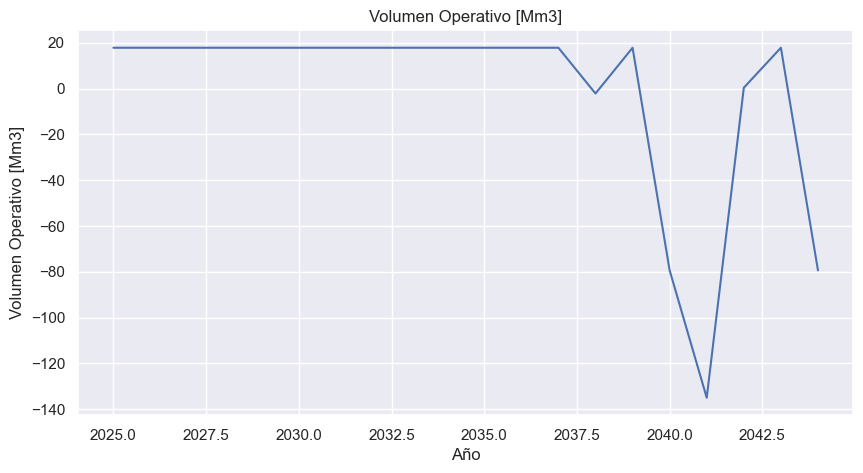

In [421]:
volumen_maximo = 250
salida_irrigacion = 79.2
perdidas = 18
años_deficit_forecast, forecast_df = balance_hidrico(serie_inlet,volumen_maximo,salida_irrigacion,perdidas)
forecast_df

### Escenario 2

Con una capacidad de 300 Mm3, un consumo de 55 Mm3 y unas pérdidas de 18 Mm3, el número de años esperado con déficit en los próximos 20 años es: 1


,year,inlet,Vt,overflow,balance_previous_year,net_volume,operative_volume
0,2025,560.321063,789.681063,489.681063,229.36,227.0,92.0
1,2026,108.933753,335.933753,35.933753,227.00,227.0,92.0
2,2027,448.983364,675.983364,375.983364,227.00,227.0,92.0
3,2028,897.305356,1124.305356,824.305356,227.00,227.0,92.0
4,2029,518.446555,745.446555,445.446555,227.00,227.0,92.0
5,2030,427.287256,654.287256,354.287256,227.00,227.0,92.0
6,2031,1111.845555,1338.845555,1038.845555,227.00,227.0,92.0
7,2032,759.844467,986.844467,686.844467,227.00,227.0,92.0
8,2033,457.621111,684.621111,384.621111,227.00,227.0,92.0
9,2034,564.681456,791.681456,491.681456,227.00,227.0,92.0


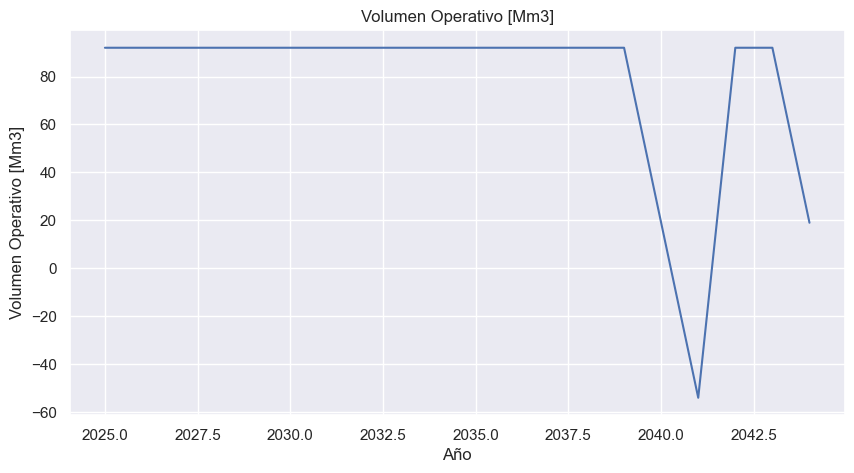

In [438]:
volumen_maximo = 300
salida_irrigacion = 55
perdidas = 18
años_deficit_forecast, forecast_df = balance_hidrico(serie_inlet,volumen_maximo,salida_irrigacion,perdidas)
forecast_df